In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [21]:
data = pd.read_csv("C:/Users/Phanthom/MEGAsync/IIT/SDGP/GitHub/Dataset/dbEnglish_v3.csv")

In [22]:
data.head(1)

,Time,Name/Nickname,Gender,Age,Maximum rating in Dota,Current Dota rating,Number of Hours ingame (atleast approximate),How many games do you play per week on average?,My mood worsens if I don't play Dota 2 for a long time,I spend almost all my free time on Dota 2,...,I have a specific goal - to upgrade the birds (for example: get 6k mmr or a medal of the lord / devine / titan),I play dota to win,"In DotA, too much depends not on me and my game","If I lose, then this is most often due to the bad game of teammates","If I had a strong team in every game, I would almost never lose",My possible pts is much bigger than my actual one,I have been sitting on the same rating for a long time without any visible progress,I often lose my desire to play when my teammates play badly,"MMR is just a number, it does not show the player's real skill","Write down the three heroes that you have played the most games on, the number and win rate on these heroes (for example: Pudge, 152 games, 56%):"
0,2021/11/07 5:29:50 PM GMT+3,???????,?,26,5300,4800,5000,NaN,4,3,...,3,1,3,1,3,4,NaN,4,4,?????? - 774 (56%)\nPudge - 146 (45%)\nSpirit ...


In [23]:
data_row = data.iloc[:, 3:-1]
data_row['Maximum rating in Dota'] = data_row['Maximum rating in Dota'].str.extract('(\d+)', expand=False)
data_row['Current Dota rating'] = data_row['Current Dota rating'].str.extract('(\d+)', expand=False)
data_row['Number of Hours ingame (atleast approximate)'] = data_row['Number of Hours ingame (atleast approximate)'].str.extract('(\d+)', expand=False)
data_row['How many games do you play per week on average?'] = data_row['How many games do you play per week on average?'].str.extract('(\d+)', expand=False)
data_row['Age'] = data_row['Age'].str.extract('(\d+)', expand=False)
df = data_row.fillna(0)
df = df.replace(to_replace = 0, value = 0)
df = df.dropna()
df = df.astype('float32')
df = df.drop(np.where(df['Current Dota rating'] > 10000)[0])
df = df.drop(np.where(df['Maximum rating in Dota'] > 10000)[0])
df = df.loc[df['Current Dota rating'] > 200]
df = df.loc[df['Maximum rating in Dota'] > 200]
df = df.loc[df['Number of Hours ingame (atleast approximate)'] > 200]
df = df.loc[df['Current Dota rating'] <= df['Maximum rating in Dota']]
df = df.loc[df['Number of Hours ingame (atleast approximate)'] < 30000]
df = df.astype('float32')
df = df.drop('Maximum rating in Dota',axis=1)

In [24]:
df['target'] = df['Current Dota rating']
df = df.drop(columns=['Current Dota rating'])

In [25]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [26]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop('target')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [27]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

C:\Users\Phanthom\AppData\Local\Temp\ipykernel_19612\3859046669.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [28]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Age', 'Number of Hours ingame (atleast approximate)', 'How many games do you play per week on average?', "My mood worsens if I don't play Dota 2 for a long time", 'I spend almost all my free time on Dota 2', "I often play more than I need to because I can't stop (register a new game)", 'When I play Dota, I\'m completely focused on it (I don\'t play "for fun")', 'Every week/month I spend more time in Dota than before', 'I often regist the next game despite discomfort (I can play hungry, sleepy, not feeling well, etc.)', "I don't tell family/friends about the number of hours I spend in Dota", 'Dota lets me forget about stress and life problems irl', 'Due to the number of hours spent in the game, I study / work / perform other tasks worse', 'Every game in DotA I play to win.', "I often play DotA pho fan - I'm interested in the process of the game itself (I try different builds, new heroes, bundles, etc.)", 'If my teammates frankly ruin the game, I can ruin them in respons

In [29]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

  # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1000])
    plt.xlabel('Epoch')
    plt.ylabel('Error [rating]')
    plt.legend()
    plt.grid(True)

In [30]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

C:\Users\Phanthom\AppData\Local\Temp\ipykernel_19612\3859046669.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\Phanthom\AppData\Local\Temp\ipykernel_19612\3859046669.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
C:\Users\Phanthom\AppData\Local\Temp\ipykernel_19612\3859046669.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [31]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['Age', 'Number of Hours ingame (atleast approximate)']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [32]:
categorical_cols = df.columns[2:-1]

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='float')
    encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='float',
                                               max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

Epoch 1/500


c:\Users\Phanthom\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:638: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


20/20 - 2s - loss: 2175.1377 - val_loss: 2134.7554 - 2s/epoch - 125ms/step
Epoch 2/500
20/20 - 0s - loss: 2163.2310 - val_loss: 2103.1267 - 160ms/epoch - 8ms/step
Epoch 3/500
20/20 - 0s - loss: 2080.1118 - val_loss: 1913.8312 - 146ms/epoch - 7ms/step
Epoch 4/500
20/20 - 0s - loss: 1716.3682 - val_loss: 1324.9908 - 160ms/epoch - 8ms/step
Epoch 5/500
20/20 - 0s - loss: 1181.8230 - val_loss: 1098.1804 - 144ms/epoch - 7ms/step
Epoch 6/500
20/20 - 0s - loss: 1103.1108 - val_loss: 1065.6686 - 258ms/epoch - 13ms/step
Epoch 7/500
20/20 - 0s - loss: 1079.9774 - val_loss: 1044.6210 - 143ms/epoch - 7ms/step
Epoch 8/500
20/20 - 0s - loss: 1060.7004 - val_loss: 1027.0116 - 156ms/epoch - 8ms/step
Epoch 9/500
20/20 - 0s - loss: 1040.2922 - val_loss: 1009.3370 - 163ms/epoch - 8ms/step
Epoch 10/500
20/20 - 0s - loss: 1019.4529 - val_loss: 991.1802 - 149ms/epoch - 7ms/step
Epoch 11/500
20/20 - 0s - loss: 996.7918 - val_loss: 969.5862 - 159ms/epoch - 8ms/step
Epoch 12/500
20/20 - 0s - loss: 972.5095 - va

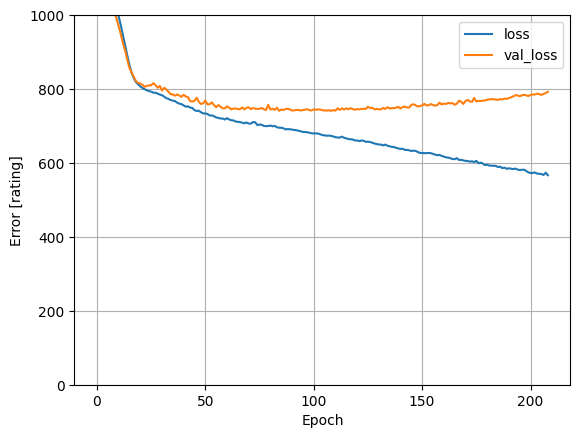

In [34]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer='l2')(all_features)
x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer='l2')(x)
x = tf.keras.layers.Dense(32, activation="relu", kernel_regularizer='l2')(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
output = tf.keras.layers.Dense(1)(x)

trained_model = tf.keras.Model(all_inputs, output)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
checkpoint_filepath = 'C:/Users/Phanthom/AppData/Local/Temp'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
trained_model.compile(optimizer=tf.keras.optimizers.Adam(
                learning_rate=0.001),
              loss='mean_absolute_error',
              )

history = trained_model.fit(train_ds, epochs=500, verbose=2, validation_data=val_ds, callbacks=[callback, model_checkpoint_callback])
plot_loss(history)
trained_model.load_weights(checkpoint_filepath)

In [19]:
def otvet(df, model):
    X_test = {}
    for i in range(0,len(df.columns[:-1])):
        print(df.columns[i], str(i+1))
        a = float(input())
        X_test[df.columns[i]] = a
    input_dict = {name: tf.convert_to_tensor([value]) for name, value in X_test.items()}
    predictions = model.predict(input_dict)
    return predictions